# Binarized Neural Avalanche Analysis & Visualization

This script analyzes and visualizes binarized neural activity, focusing on "avalanches."

---

## Neural Avalanche Definition

Let $x_i(t) \in \{0, 1\}$ be the binarized activity of channel $i$ at time $t$.

We define the **total network activity** at time $t$ as:
$$A(t) = \sum_{i=1}^{N} x_i(t)$$

A **neural avalanche** is a contiguous time interval $[t_{start}, t_{end})$ such that:
1.  $A(t_{start}-1) = 0$ (the network is silent just before it begins).
2.  $A(t) > 0$ for all $t \in [t_{start}, t_{end}-1]$ (the network is active throughout the avalanche).
3.  $A(t_{end}) = 0$ (the network returns to silence immediately after it ends).

---

## Methodology

1.  **Load Data:** Imports a patient's 80-channel binarized signal.
2.  **Detect Avalanches:** Identifies global network avalanches based on the above definition.
3.  **Segment Data:** Filters signals to retain activity *only during* these detected avalanches.
4.  **Select Channels:** Focuses on a subset of channels (e.g., first 5) for analysis.
5.  **Visualize:** Plots the binarized activity of selected channels during avalanches using a step-like style with vertical offsets for clarity.

---

## Plot Interpretation

The plot displays individual channel activity *specifically within* periods of network-wide neural avalanches, helping visualize their internal structure.

Loading patient 00 from '../data/patients_criticality/patient_00.pkl'...
Original binarized signal shape: (80, 20000)

Detected 1684 global avalanches for patient 00.
Binarized signal shape during global avalanches: (80, 17559)

--- Avalanche Signals for First 5 Channels ---
Shape: (5, 17559)

Generating plot of the first 5 avalanche signals...


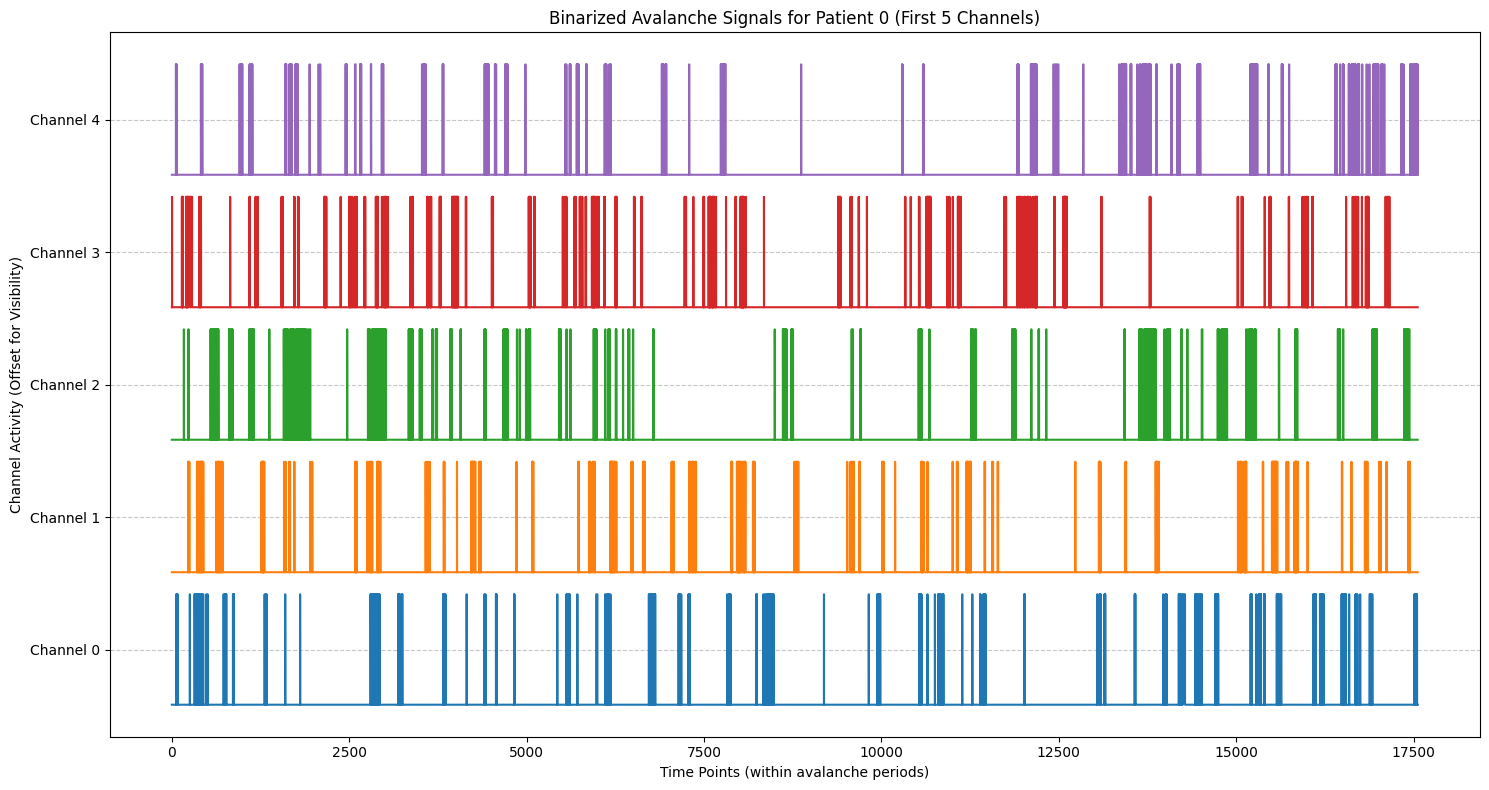


The plot has been generated, showing the binarized activity of the first 5 channels *only during* global avalanche periods.


In [3]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt # Import matplotlib

# --- Configuration ---
# Directory where patient .pkl files are located
# Ensure this path is correct on your system
INPUT_DIR = "../data/patients_criticality" 

# --- Helper Function: Avalanche Detection (reused from previous code) ---
def detect_avalanches(binarized_signal):
    """
    Detects avalanches in a binarized multivariate time series.
    An avalanche is defined as a contiguous period of activity (sum of active channels > 0)
    preceded and followed by a period of no activity (sum of active channels = 0).

    Args:
        binarized_signal (np.ndarray): Binarized signal for one patient (n_channels, time_points).

    Returns:
        list: A list of tuples, where each tuple (start_idx, end_idx) represents
              the inclusive start and exclusive end time points of an avalanche.
    """
    # Sum activity across all channels at each time point
    total_activity = np.sum(binarized_signal, axis=0) # Shape: (time_points,)
    
    # Identify active time points (where total activity > 0)
    active_time_points = total_activity > 0
    
    avalanches = []
    in_avalanche = False
    avalanche_start = -1

    for t in range(len(total_activity)):
        if active_time_points[t] and not in_avalanche:
            # Avalanche starts
            in_avalanche = True
            avalanche_start = t
        elif not active_time_points[t] and in_avalanche:
            # Avalanche ends
            avalanches.append((avalanche_start, t)) # 't' is the exclusive end
            in_avalanche = False
            avalanche_start = -1 # Reset
            
    # Handle case where avalanche extends to the end of the time series
    if in_avalanche:
        avalanches.append((avalanche_start, len(total_activity)))
        
    return avalanches

# --- Example Code for 1 Patient, First 5 Channels and Plotting ---
if __name__ == "__main__":
    patient_idx = 0 # Load the first patient (patient_00.pkl)
    num_channels_to_examine = 5 # Focus only on the first 5 channels

    patient_filename = os.path.join(INPUT_DIR, f"patient_{patient_idx:02d}.pkl")

    if not os.path.exists(patient_filename):
        print(f"Error: Patient file not found at {patient_filename}.")
        print(f"Please ensure the path '{INPUT_DIR}' is correct and 'patient_{patient_idx:02d}.pkl' exists.")
    else:
        print(f"Loading patient {patient_idx:02d} from '{patient_filename}'...")
        with open(patient_filename, 'rb') as f:
            patient_data = pickle.load(f)
        
        binarized_signal = patient_data['binarized_signal']
        n_channels, time_points = binarized_signal.shape
        
        print(f"Original binarized signal shape: {binarized_signal.shape}")

        # 1. Detect global avalanches for this patient
        detected_avalanches = detect_avalanches(binarized_signal)
        print(f"\nDetected {len(detected_avalanches)} global avalanches for patient {patient_idx:02d}.")

        # 2. Create a mask for time points *during* global avalanches
        during_avalanche_mask = np.zeros(time_points, dtype=bool)
        for start, end in detected_avalanches:
            during_avalanche_mask[start:end] = True
        
        # 3. Apply the mask to the full binarized signal to get only avalanche periods
        # This extracts the activity of *all* channels ONLY when a global avalanche is happening.
        binarized_signal_during_avalanches = binarized_signal[:, during_avalanche_mask]
        
        print(f"Binarized signal shape during global avalanches: {binarized_signal_during_avalanches.shape}")

        # 4. Extract the signals for the first 5 channels during avalanche periods
        # These are the "avalanche signals for each channel" as requested.
        avalanche_signals_first_5_channels = binarized_signal_during_avalanches[:num_channels_to_examine, :]
        
        print(f"\n--- Avalanche Signals for First {num_channels_to_examine} Channels ---")
        print(f"Shape: {avalanche_signals_first_5_channels.shape}")
        
        # --- PLOTTING BINARIZED SIGNALS ---
        print(f"\nGenerating plot of the first {num_channels_to_examine} avalanche signals...")
        
        fig, ax = plt.subplots(figsize=(15, 8))
        
        # For better visibility, offset each channel vertically
        vertical_offset = 1.2 # Spacing between each plotted channel
        
        # Create a time array for plotting the avalanche signals
        # If no time points during avalanches, this might be an empty array
        time_points_avalanche_segment = np.arange(avalanche_signals_first_5_channels.shape[1])

        for ch_idx in range(num_channels_to_examine):
            # Plot using 'step-post' to visualize as a binary (step-like) signal
            # Offset vertically using (ch_idx * vertical_offset)
            ax.step(time_points_avalanche_segment, 
                    avalanche_signals_first_5_channels[ch_idx, :] + (ch_idx * vertical_offset), 
                    where='post', 
                    label=f'Channel {ch_idx}')
        
        ax.set_title(f'Binarized Avalanche Signals for Patient {patient_idx} (First {num_channels_to_examine} Channels)')
        ax.set_xlabel('Time Points (within avalanche periods)')
        ax.set_ylabel('Channel Activity (Offset for Visibility)')
        
        # Adjust Y-axis ticks to match channel offsets
        # If a signal is 0 or 1, and offset by 1.2*ch_idx, its values will be 0 + offset or 1 + offset
        # We can place Y-ticks in the center of each channel's 'band', e.g., at 0.5 + offset
        yticks_positions = [ch_idx * vertical_offset + 0.5 for ch_idx in range(num_channels_to_examine)]
        yticks_labels = [f'Channel {ch_idx}' for ch_idx in range(num_channels_to_examine)]
        ax.set_yticks(yticks_positions)
        ax.set_yticklabels(yticks_labels)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.show()

        print("\nThe plot has been generated, showing the binarized activity of the first 5 channels *only during* global avalanche periods.")

# Neural Avalanche Processing for Synthetic Patients

This script processes binarized neural activity from **synthetically created patients**. It identifies and segments network-wide **neural avalanches**, preparing the data for subsequent analysis of higher-order interactions within these critical periods.

In [4]:
import numpy as np
import os
import pickle

# --- Configuration ---
# Define the input directory where the generated patient data (binarized signals) is stored.
INPUT_DIR = "../data/patients_criticality"
# Define the output directory where the results of avalanche detection and segmentation will be saved.
OUTPUT_RESULTS_DIR = "../results/avalanches"
# Specify the total number of patients to process in this script.
NUM_PATIENTS = 20

# --- Helper Function: Avalanche Detection ---
def detect_avalanches(binarized_signal):
    """
    Detects neural avalanches in a binarized multivariate time series.

    An avalanche is defined as a contiguous period of network activity
    (where the sum of active channels is greater than 0) that is
    preceded and followed by a period of complete network silence
    (where the sum of active channels is 0).

    Args:
        binarized_signal (np.ndarray): The binarized signal for a single patient.
                                       Expected shape: (number_of_channels, number_of_time_points).

    Returns:
        list: A list of tuples, where each tuple (start_idx, end_idx) represents
              the inclusive start time point and exclusive end time point of an avalanche.
    """
    # Calculate the total network activity at each time point by summing across all channels.
    # If total_activity[t] > 0, at least one channel is active at time t.
    # If total_activity[t] == 0, the entire network is silent at time t.
    total_activity = np.sum(binarized_signal, axis=0) # Resulting shape: (number_of_time_points,)
    
    # Create a boolean array indicating whether the network is active (True) or silent (False)
    # at each time point.
    active_time_points = total_activity > 0
    
    avalanches = []      # List to store the detected avalanche intervals.
    in_avalanche = False # Flag to track if we are currently inside an avalanche.
    avalanche_start = -1 # Stores the start time index of the current avalanche.

    # Iterate through each time point to detect avalanche boundaries.
    for t in range(len(total_activity)):
        # Condition to detect the start of an avalanche:
        # The network becomes active (active_time_points[t] is True) AND
        # we were not previously in an avalanche (in_avalanche is False).
        if active_time_points[t] and not in_avalanche:
            in_avalanche = True      # Set flag to indicate we are now inside an avalanche.
            avalanche_start = t      # Record the starting time point.
        # Condition to detect the end of an avalanche:
        # The network becomes silent (active_time_points[t] is False) AND
        # we were previously inside an avalanche (in_avalanche is True).
        elif not active_time_points[t] and in_avalanche:
            # An avalanche has just ended. Store its interval.
            avalanches.append((avalanche_start, t)) # 't' is the exclusive end time point.
            in_avalanche = False     # Reset flag.
            avalanche_start = -1     # Reset start index.
            
    # Handle the special case where an avalanche extends all the way to the end
    # of the simulated time series without a clear 'silent' ending point within the data.
    if in_avalanche:
        avalanches.append((avalanche_start, len(total_activity)))
        
    return avalanches

# --- Main Script to Process All Patients ---
if __name__ == "__main__":
    # Create the output directory if it doesn't already exist.
    os.makedirs(OUTPUT_RESULTS_DIR, exist_ok=True)
    print(f"Output directory '{OUTPUT_RESULTS_DIR}' ensured.")

    print(f"Starting avalanche detection and segmentation for {NUM_PATIENTS} patients...")

    # Loop through each patient from 0 to NUM_PATIENTS - 1.
    for i in range(NUM_PATIENTS):
        # Construct the full path to the current patient's data file.
        patient_filename = os.path.join(INPUT_DIR, f"patient_{i:02d}.pkl")

        # Check if the patient file exists. If not, print a warning and skip to the next patient.
        if not os.path.exists(patient_filename):
            print(f"Warning: Patient file not found at {patient_filename}. Skipping this patient.")
            continue
        
        print(f"\n--- Processing Patient {i:02d} ---")
        
        # Load the binarized signal and other data for the current patient.
        with open(patient_filename, 'rb') as f:
            patient_data = pickle.load(f)
        
        # Extract the binarized signal from the loaded data.
        binarized_signal = patient_data['binarized_signal']
        # Get the number of channels and total time points from the signal's shape.
        n_channels, time_points = binarized_signal.shape
        
        print(f"Binarized signal shape: {binarized_signal.shape}")

        # 1. Detect Avalanches for the current patient.
        detected_avalanches = detect_avalanches(binarized_signal)
        print(f"Detected {len(detected_avalanches)} avalanches.")
        # Optional: Uncomment the following lines to print detailed information for each detected avalanche.
        # for j, (start, end) in enumerate(detected_avalanches):
        #     print(f"  Avalanche {j+1}: Start={start}, End={end} (Duration={end-start} time points)")

        # 2. Segment Data into "During Avalanches" and "Outside Avalanches".
        # Create a boolean mask to mark time points that fall within any detected avalanche.
        during_avalanche_mask = np.zeros(time_points, dtype=bool)
        for start, end in detected_avalanches:
            during_avalanche_mask[start:end] = True # Set True for all time points within the avalanche.
            
        # Create an inverse mask to mark time points that are outside any avalanche (i.e., network silence).
        outside_avalanche_mask = ~during_avalanche_mask # The '~' operator inverts the boolean array.

        # Apply the masks to the original binarized signal to get the segmented data.
        # binarized_during_avalanches will contain only the columns (time points)
        # where a global avalanche was active.
        binarized_during_avalanches = binarized_signal[:, during_avalanche_mask]
        # binarized_outside_avalanches will contain only the columns (time points)
        # where the network was silent.
        binarized_outside_avalanches = binarized_signal[:, outside_avalanche_mask]

        print(f"  Time points during avalanches: {binarized_during_avalanches.shape[1]}")
        print(f"  Time points outside avalanches: {binarized_outside_avalanches.shape[1]}")
        
        # 3. Save Segmented Data for the current patient.
        # Compile all relevant avalanche-related results into a dictionary.
        avalanche_results = {
            'binarized_during_avalanches': binarized_during_avalanches,
            'binarized_outside_avalanches': binarized_outside_avalanches,
            'detected_avalanche_intervals': detected_avalanches, # Store the list of avalanche intervals for reference.
            'original_patient_params': patient_data['parameters'] # Include original simulation parameters for traceability.
        }
        
        # Define the output filename for this patient's avalanche results.
        output_filename = os.path.join(OUTPUT_RESULTS_DIR, f"patient_{i:02d}_avalanches.pkl")
        # Save the results dictionary to a pickle file.
        with open(output_filename, 'wb') as f:
            pickle.dump(avalanche_results, f)
            
        print(f"  Segmented data saved to '{output_filename}'")

    print("\nAll patients processed successfully for avalanche detection and segmentation.")
    print(f"Results are stored in '{OUTPUT_RESULTS_DIR}'.")

Output directory '../results/avalanches' ensured.
Starting avalanche detection and segmentation for 20 patients...

--- Processing Patient 00 ---
Binarized signal shape: (80, 20000)
Detected 1684 avalanches.
  Time points during avalanches: 17559
  Time points outside avalanches: 2441
  Segmented data saved to '../results/avalanches/patient_00_avalanches.pkl'

--- Processing Patient 01 ---
Binarized signal shape: (80, 20000)
Detected 1664 avalanches.
  Time points during avalanches: 17681
  Time points outside avalanches: 2319
  Segmented data saved to '../results/avalanches/patient_01_avalanches.pkl'

--- Processing Patient 02 ---
Binarized signal shape: (80, 20000)
Detected 1715 avalanches.
  Time points during avalanches: 17478
  Time points outside avalanches: 2522
  Segmented data saved to '../results/avalanches/patient_02_avalanches.pkl'

--- Processing Patient 03 ---
Binarized signal shape: (80, 20000)
Detected 1779 avalanches.
  Time points during avalanches: 17503
  Time point